In [5]:

import geopandas as gpd
import us
import pandas as pd
import libpysal

import pandas as pd
from helpers import (
    plot_lisa_analysis,
    plot_moran_scatter,
    calculate_moran_i_report,
    calculate_moran_local_bv,
)



<Axes: >

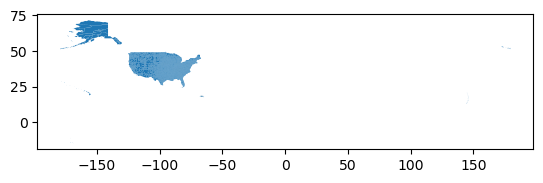

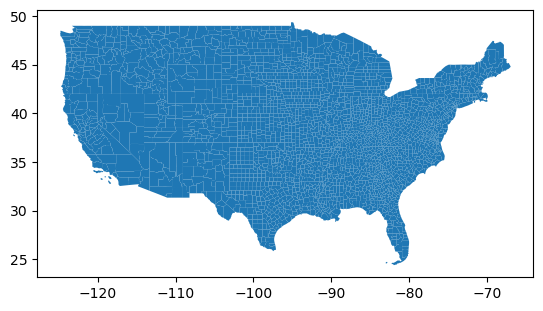

In [6]:
# %% Download and clean county files
# !wget https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip
# !unzip tl_2017_us_county.zip

# %% Read in county file
county = gpd.read_file("tl_2017_us_county.shp")
county.plot()

# %% Limit to ConUS
exclude_states = [
    us.states.GU.fips,
    us.states.AS.fips,
    us.states.MP.fips,
    us.states.PR.fips,
    us.states.AK.fips,
    us.states.HI.fips,
    us.states.VI.fips,
]

county = county[~county["STATEFP"].isin(exclude_states)]
county.plot()

In [7]:
# !wget https://files.consumerfinance.gov/hmda-historic-loan-data/hmda_2017_nationwide_first-lien-owner-occupied-1-4-family-records_labels.zip
# !unzip hmda_2017_nationwide_first-lien-owner-occupied-1-4-family-records_labels.zip

# %% Read in loan data
hmda = pd.read_csv(
    "/mnt/bigdrive/Dropbox/Treasury_IPA/Clustering Tutorial/hmda_2017_nationwide_first-lien-owner-occupied-1-4-family-records_labels.csv",
    engine="pyarrow",
)
hmda.head()

# limit to approved or purchased loans
hmda = hmda[(hmda["action_taken"] == 1) | (hmda["action_taken"] == 6)]

# get loans by type
loans = (
    hmda.groupby(
        ["state_code", "county_code", "loan_type_name", "purchaser_type"],
        as_index=False,
    )
    .agg(
        total_loan_amount=("loan_amount_000s", "sum"),
        avg_loan_amount=("loan_amount_000s", "mean"),
        fam_income_med=("hud_median_family_income", "mean"),
    )
    .dropna()
)


In [8]:
# standarize FIPS codes
loans["STATEFP"] = loans["state_code"].astype(int).astype(str).str.zfill(2)
loans["COUNTYFP"] = loans["county_code"].astype(int).astype(str).str.zfill(3)

# Set purchaser type to be categorical
loans["sold"] = pd.cut(
    loans["purchaser_type"],
    bins=[0, 1, 4, 10],
    labels=["not_sold", "GSE", "sold_other"],
    include_lowest=True,
)

/tmp/ipykernel_3954711/4157892722.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loans.groupby(["STATEFP", "COUNTYFP", "sold"])


Text(0.5, 1.0, 'Loan-to-Income Ratio Loans Sold to GSE')

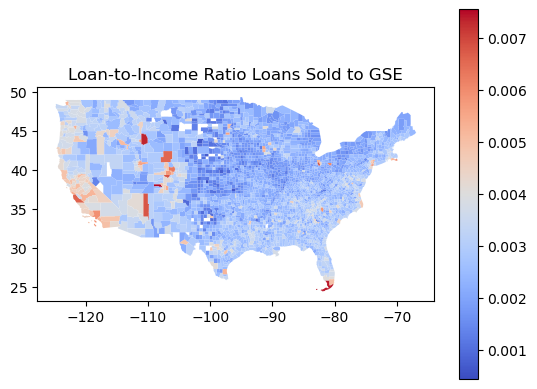

In [9]:
# Isolate loans sold to GSE
loans_sold = (
    loans.groupby(["STATEFP", "COUNTYFP", "sold"])
    .agg(
        total_loan_amount=("total_loan_amount", "sum"),
        avg_loan_amount=("avg_loan_amount", "mean"),
        fam_income_med=("fam_income_med", "mean"),
    )
    .reset_index()
)
loans_sold

# %% Merge boundaries / loans
cnt_GSE_loans = pd.merge(
    county,
    loans_sold[loans_sold["sold"] == "GSE"],
    on=["STATEFP", "COUNTYFP"],
    how="left",
    validate="one_to_one",
)
cnt_GSE_loans["loan_income_ratio"] = (
    cnt_GSE_loans["avg_loan_amount"] / cnt_GSE_loans["fam_income_med"]
)
# cnt_loans.plot('avg_loan_amount')
# cnt_loans.plot('total_loan_amount')
# cnt_loans.plot('fam_income_med')
# cnt_loans.plot('loan_income_ratio')
ax = cnt_GSE_loans.plot("loan_income_ratio", cmap="coolwarm", legend=True)
ax.set_title("Loan-to-Income Ratio Loans Sold to GSE")


Text(0.5, 1.0, 'Loan-to-Income Ratio for Not Sold Loans')

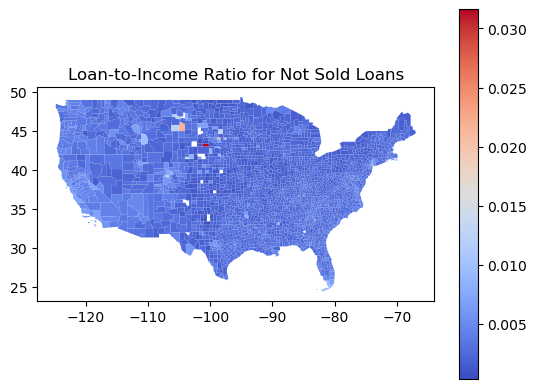

In [10]:
# Isolate loans not sold
cnt_notsold_loans = pd.merge(
    county,
    loans_sold[loans_sold["sold"] == "not_sold"],
    on=["STATEFP", "COUNTYFP"],
    how="left",
    validate="one_to_one",
)
cnt_notsold_loans["loan_income_ratio"] = (
    cnt_notsold_loans["avg_loan_amount"] / cnt_notsold_loans["fam_income_med"]
)
# cnt_notsold_loans.plot('avg_loan_amount', cmap="coolwarm")
# cnt_notsold_loans.plot('total_loan_amount', cmap="coolwarm")
# cnt_notsold_loans.plot('fam_income_med',cmap="coolwarm")
ax = cnt_notsold_loans.plot("loan_income_ratio", cmap="coolwarm", legend=True)
ax.set_title("Loan-to-Income Ratio for Not Sold Loans")


Text(0.5, 1.0, 'Loan-to-Income Ratio GSE')

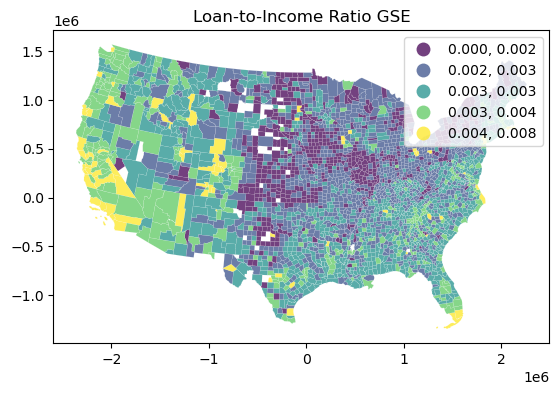

In [13]:
# Bring loans sold and not sold together into county geodataframe

# Keep only the variables of interest
keep_variables = [
    "STATEFP",
    "COUNTYFP",
    "NAME",
    "geometry",
    "total_loan_amount",
    "avg_loan_amount",
    "fam_income_med",
    "loan_income_ratio",
]


# Merge the two dataframes
common_loans = pd.merge(
    left=cnt_GSE_loans[keep_variables].dropna(subset=["loan_income_ratio"]),
    right=cnt_notsold_loans[keep_variables].dropna(subset=["loan_income_ratio"]),
    on=["STATEFP", "COUNTYFP"],
    how="inner",
    validate="one_to_one",
    suffixes=("_GSE", "_not_sold"),
)
common_loans = common_loans.drop(columns="geometry_not_sold").rename(
    columns={"geometry_GSE": "geometry"}
)
common_loans = common_loans.set_geometry("geometry").to_crs("ESRI:102003")

# %% Drop one outlier
common_loans = common_loans[common_loans["loan_income_ratio_not_sold"] < 0.025]


# %% Plot variables of interest
ax = common_loans.plot(
    "loan_income_ratio_GSE",
    # cmap="plasma",
    scheme="NaturalBreaks",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    legend_kwds={"fmt": "{:.3f}"},  # Show 4 decimal places
)
ax.set_title("Loan-to-Income Ratio GSE")


Text(0.5, 1.0, 'Loan-to-Income Ratio not sold')

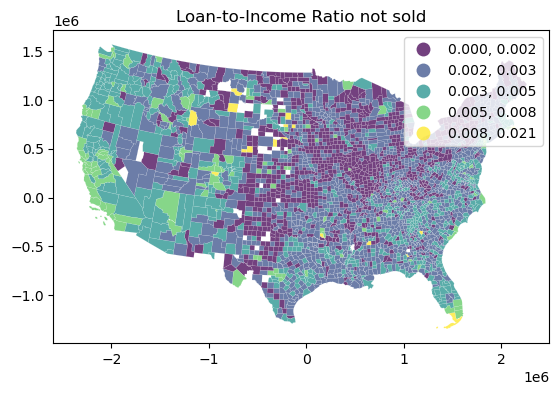

In [14]:

ax = common_loans.plot(
    "loan_income_ratio_not_sold",
    # cmap="plasma",
    scheme="NaturalBreaks",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    legend_kwds={"fmt": "{:.3f}"},  # Show 4 decimal places
)
ax.set_title("Loan-to-Income Ratio not sold")



In [23]:
#  Create the weights matrix from the filtered data

w = libpysal.weights.Queen.from_dataframe(common_loans)
w.transform = "R"  # Row-standardize the weights


/tmp/ipykernel_3954711/1396731133.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(common_loans)


In [24]:
# %% Moran's I value
# Calculate for GSE loans
mi_gse = calculate_moran_i_report(common_loans, "loan_income_ratio_GSE", w)
mi_gse
# Calculate for not-sold loans
mi_not_sold = calculate_moran_i_report(common_loans, "loan_income_ratio_not_sold", w)
mi_not_sold


Moran's I Analysis for loan_income_ratio_GSE:
I value: 0.5334
p-value: 0.0000
Interpretation: The data shows moderate positive spatial autocorrelation (clustered) and is statistically significant (p=0.0000).
-------------------------------------------------------
Moran's I Analysis for loan_income_ratio_not_sold:
I value: 0.3406
p-value: 0.0000
Interpretation: The data shows moderate positive spatial autocorrelation (clustered) and is statistically significant (p=0.0000).
-------------------------------------------------------


<Axes: title={'center': 'no_sold'}, xlabel='loan_income_ratio_not_sold', ylabel='w_loan_income_ratio_not_sold'>

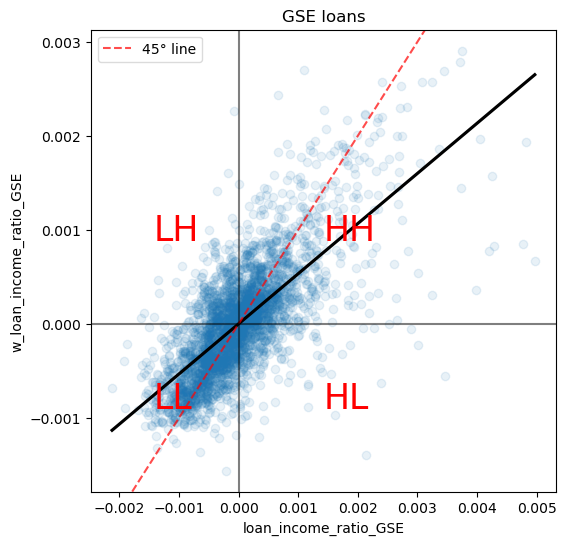

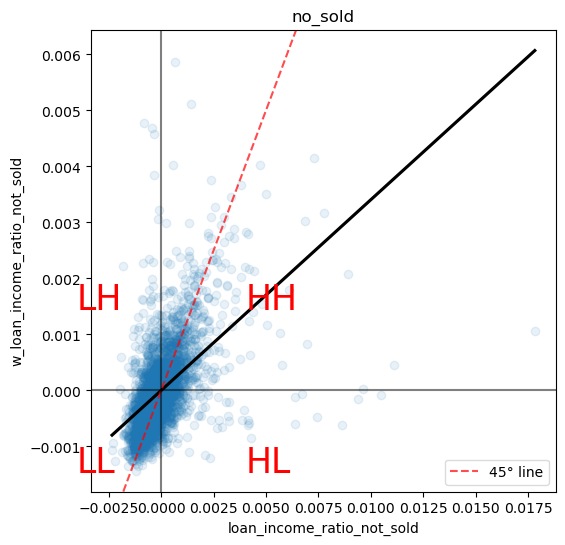

In [ ]:
#  Moran's Scatter
plot_moran_scatter(
    x="loan_income_ratio_GSE", weights=w, data=common_loans, title="GSE loans"
)

plot_moran_scatter(
    x="loan_income_ratio_not_sold", weights=w, data=common_loans, title="no_sold"
)


In [ ]:

# %%
from splot.esda import plot_local_autocorrelation, moran_scatterplot
from esda.moran import Moran_Local

plot_local_autocorrelation(
    moran_loc=Moran_Local(common_loans["loan_income_ratio_GSE"].values, w),
    gdf=common_loans,
    attribute="loan_income_ratio_GSE",
)
# %%
moran_scatterplot(Moran_Local(common_loans["loan_income_ratio_GSE"].values, w), p=0.05)

# %%
from esda.moran import Moran, Moran_BV, Moran_Local, Moran_Local_BV

moran_scatterplot(
    Moran_Local_BV(
        common_loans["loan_income_ratio_GSE"].values,
        common_loans["loan_income_ratio_not_sold"].values,
        w,
    ),
    p=0.05,
)

# %% interactive local morans bivariate

quadrant_GSEvNotSold = calculate_moran_local_bv(
    gdf=common_loans,
    x_name="loan_income_ratio_GSE",
    y_name="loan_income_ratio_not_sold",
    w=w,
)

# %%
quadrant_GSEvNotSold.explore(
    color=quadrant_GSEvNotSold["quadrant_label"].map(
        {
            "HH": "red",
            "LL": "blue",
            "HL": "orange",
            "LH": "lightblue",
            "NS": "lightgrey",
        }
    ),
    tooltip=False,
    popup=True,
)
# %%
# %% Lisa PLots - single variable
plot_lisa_analysis(
    df=common_loans,
    x_name="loan_income_ratio_GSE",
    w=w,
    title_prefix="loan_income_ratio_GSE",
    legend_kwds={"fmt": "{:.4f}"},
)
# %%
plot_lisa_analysis(
    df=common_loans,
    x_name="loan_income_ratio_not_sold",
    w=w,
    title_prefix="",
    legend_kwds={"fmt": "{:.4f}"},
)


# %% Lisa Plot - multivariable

plot_lisa_analysis(
    df=common_loans,
    x_name="loan_income_ratio_GSE",
    y_name="loan_income_ratio_not_sold",
    w=w,
    title_prefix="GSE/nosold",
    legend_kwds={"fmt": "{:.4f}"},
)